In [91]:
"""
Interactive tool to draw mask on an image or image-like array.
Adapted from matplotlib/examples/event_handling/poly_editor.py
"""
import numpy as np

# import matplotlib as mpl
# mpl.use('tkagg')
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.mlab import dist_point_to_segment
from matplotlib.path import Path

class MaskCreator(object):
    """An interactive polygon editor.
    Parameters
    ----------
    poly_xy : list of (float, float)
        List of (x, y) coordinates used as vertices of the polygon.
    max_ds : float
        Max pixel distance to count as a vertex hit.
    Key-bindings
    ------------
    't' : toggle vertex markers on and off.  When vertex markers are on,
          you can move them, delete them
    'd' : delete the vertex under point
    'i' : insert a vertex at point.  You must be within max_ds of the
          line connecting two existing vertices
    """
    def __init__(self, ax, poly_xy=None, max_ds=10):
        self.showverts = True
        self.max_ds = max_ds
        if poly_xy is None:
            poly_xy = self.default_vertices(ax)
        self.poly = Polygon(poly_xy, animated=True,
                            fc='y', ec='none', alpha=0.4)

        ax.add_patch(self.poly)
        ax.set_clip_on(False)
        ax.set_title("Click and drag a point to move it; "
                     "'i' to insert; 'd' to delete.\n"
                     "Close figure when done.")
        self.ax = ax

        x, y = zip(*self.poly.xy)
        self.line = plt.Line2D(x, y, color='none', marker='o', mfc='r',
                               alpha=0.2, animated=True)
        self._update_line()
        self.ax.add_line(self.line)

        self.poly.add_callback(self.poly_changed)
        self._ind = None # the active vert

        canvas = self.poly.figure.canvas
        canvas.mpl_connect('draw_event', self.draw_callback)
        canvas.mpl_connect('button_press_event', self.button_press_callback)
        canvas.mpl_connect('button_release_event', self.button_release_callback)
        canvas.mpl_connect('key_press_event', self.key_press_callback)
        canvas.mpl_connect('motion_notify_event', self.motion_notify_callback)
        self.canvas = canvas

        plt.ion()
        plt.show()

    def default_vertices(self, ax):
        """Default to rectangle that has a quarter-width/height border."""
        xlims  = ax.get_xlim()
        ylims  = ax.get_ylim()
        w      = np.diff(xlims)
        h      = np.diff(ylims)
        x1, x2 = xlims + w // 4 * np.array([1, -1])
        y1, y2 = ylims + h // 4 * np.array([1, -1])
        return ((x1, y1), (x1, y2), (x2, y2), (x2, y1))


    def get_mask(self, x_grid, y_grid):
        """Return image mask given by mask creator"""
        points = np.transpose((x_grid.ravel(), y_grid.ravel()))

        path = Path(self.verts)
        mask = path.contains_points( points )

        mask = mask.reshape(x_grid.shape)

        return mask.T

    def get_pts_in_path(self, pts):
        path        = Path(self.verts)
        pts_in_path = path.contains_points( pts )
        return pts[pts_in_path]

    def poly_changed(self, poly):
        'this method is called whenever the polygon object is called'
        # only copy the artist props to the line (except visibility)
        vis = self.line.get_visible()
        #Artist.update_from(self.line, poly)
        self.line.set_visible(vis)  # don't use the poly visibility state

    def draw_callback(self, event):
        self.background = self.canvas.copy_from_bbox(self.ax.bbox)
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)

    def button_press_callback(self, event):
        'whenever a mouse button is pressed'
        ignore = not self.showverts or event.inaxes is None or event.button != 1
        if ignore:
            return
        self._ind = self.get_ind_under_cursor(event)

    def button_release_callback(self, event):
        'whenever a mouse button is released'
        ignore = not self.showverts or event.button != 1
        if ignore:
            return
        self._ind = None

    def key_press_callback(self, event):
        'whenever a key is pressed'
        if not event.inaxes:
            return
        if event.key=='t':
            self.showverts = not self.showverts
            self.line.set_visible(self.showverts)
            if not self.showverts:
                self._ind = None
        elif event.key=='d':
            ind = self.get_ind_under_cursor(event)
            if ind is None:
                return
            if ind == 0 or ind == self.last_vert_ind:
                print("Cannot delete root node")
                return
            self.poly.xy = [tup for i,tup in enumerate(self.poly.xy)
                                if i!=ind]
            self._update_line()
        elif event.key=='i':
            xys = self.poly.get_transform().transform(self.poly.xy)
            p = event.x, event.y # cursor coords
            for i in range(len(xys)-1):
                s0 = xys[i]
                s1 = xys[i+1]
                d = dist_point_to_segment(p, s0, s1)
                if d <= self.max_ds:
                    self.poly.xy = np.array(
                        list(self.poly.xy[:i+1]) +
                        [(event.xdata, event.ydata)] +
                        list(self.poly.xy[i+1:]))
                    self._update_line()
                    break
        self.canvas.draw()

    def motion_notify_callback(self, event):
        'on mouse movement'
        ignore = (not self.showverts or event.inaxes is None or
                  event.button != 1 or self._ind is None)
        if ignore:
            return
        x,y = event.xdata, event.ydata

        if self._ind == 0 or self._ind == self.last_vert_ind:
            self.poly.xy[0] = x,y
            self.poly.xy[self.last_vert_ind] = x,y
        else:
            self.poly.xy[self._ind] = x,y
        self._update_line()

        self.canvas.restore_region(self.background)
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)

    def _update_line(self):
        # save verts because polygon gets deleted when figure is closed
        self.verts = self.poly.xy
        self.last_vert_ind = len(self.poly.xy) - 1
        self.line.set_data(zip(*self.poly.xy))

    def get_ind_under_cursor(self, event):
        'get the index of the vertex under cursor if within max_ds tolerance'
        # display coords
        xy = np.asarray(self.poly.xy)
        xyt = self.poly.get_transform().transform(xy)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.sqrt((xt - event.x)**2 + (yt - event.y)**2)
        indseq = np.nonzero(np.equal(d, np.amin(d)))[0]
        ind = indseq[0]
        if d[ind] >= self.max_ds:
            ind = None
        return ind

In [104]:
#!/usr/bin/env python3
#Scourinator file, included here for simplicity
from scipy.interpolate import griddata
import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib.path import Path
import matplotlib.patches as patches
#import polyedit
import sys
import pickle
from scipy.spatial import ConvexHull

#Code to read with Numpy, but I suspect you'll want pandas so you can filter by
#rows easier
# treedat   = np.loadtxt('913aadj.txt')
# seddat    = np.loadtxt('913adjfill.txt')
# treeflags = treedat[:,0]
# treedat   = treedat[:,1:]
# sedflags  = seddat[:,0]
# seddat    = seddat[:,1:]

class Scourinator:
  def __init__(self, sedfile, treefile, step_size=0.1):
    seddat          = pd.read_table(sedfile,    names=['flag','x','y','z'])
    seddat['type']  = 'sed'
    treedat         = pd.read_table(treefile, names=['flag','x','y','z'])
    treedat['type'] = 'tree'
    #Combine data into same data frame
    self.dat = pd.concat((treedat,seddat))

    #Get bounds for interpolated data
    gxmin = min(self.dat['x'])
    gymin = min(self.dat['y'])
    gxmax = max(self.dat['x'])
    gymax = max(self.dat['y'])
    gxran = abs(gxmax-gxmin)
    gyran = abs(gymax-gymin)
    gxmin -= 0.05*gxran
    gxmax += 0.05*gxran
    gymin -= 0.05*gyran
    gymax += 0.05*gyran

    #No region of interest, initially
    self.roi        = None
    self.roi_path   = None
    self.use_roi    = True
    self.roi_points = None
    self.step_size  = step_size

    #Separate out the sediment data
    self.sed_data     = self.dat.loc[self.dat['type'] == 'sed'].copy()

    #Mash points into array
    #Take the columns x,y,z and zip them together into a list of (x,y,z) tuples
    #Turn this list of tuples into a numpy array    
    self.sed_data_arr = np.array(list(zip(self.sed_data['x'], self.sed_data['y'], self.sed_data['z'])))

    #Get z-values. Useful for plotting
    self.zmin = min(self.sed_data['z'])
    self.zmax = max(self.sed_data['z'])
    self.zran = self.zmax-self.zmin

    #Get the outline of the tree
    ttemp         = self.dat.loc[self.dat['type'] == 'tree'] #Extract tree data frame data frame
    verts         = list(zip(ttemp['x'],ttemp['y']))         #Build list of (x,y) pairs of the points of the tree
    codes         = [Path.LINETO]*len(verts)                 #Build list of codes equal to length of list of (x,y) pairs
    codes[0]      = Path.MOVETO                              #Set first code to MOVETO
    codes[-1]     = Path.CLOSEPOLY                           #Set last code to CLOSEPOLY
    self.treepath = Path(verts, codes)                       #Create a path

    #Generate plotting grid with 100 steps along both axes
    self.grid_x, self.grid_y = np.mgrid[gxmin:gxmax+1e-6:self.step_size, gymin:gymax+1e-6:self.step_size]

  def useROI(self, use_roi):
    self.use_roi = use_roi

  #If roi_points is none, then we bring up an interactive window to select them; otherwise, set them
  def setROI(self, roi_points=None):
    if not roi_points is None:
        try:
            roi_points = pickle.loads(roi_points)
        except:
            pass
        self.roi_points = roi_points
        return

    fig     = plt.figure()
    ax      = fig.add_subplot(111)
    surfdat = self.getSedSurface(roi=False,zcutoff=None)
    surf    = self.surfaceImage(ax, surfdat)
    mc      = MaskCreator(ax, poly_xy=self.roi_points)

    #Add the tree to the picture
    patch    = patches.PathPatch(self.treepath, facecolor='#FFA400', lw=1) #Create a patch from the path
    ax.add_patch(patch)                                                    #Draw the patch

    #Plot sediment points we interpolated from
    ax.plot(self.sed_data['x'], self.sed_data['y'], 'k.', ms=3)                      

    #Show the MaskCreator
    plt.show()

    self.roi         = mc.get_mask(self.grid_x, self.grid_y)
    #self.roi_points = mc.get_pts_in_path(list(zip(si.sed_data['x'],si.sed_data['y'])))
    self.roi_points  = mc.verts
    #self.roi_points = mc.get_pts_in_path(self.sed_data_arr[:,0:2])

    return self.roi_points

  #Returns <Included, Excluded>
  def getPoints(self, zcutoff=None):
    allpts = self.sed_data_arr.copy()
    hull   = ConvexHull(allpts)
    hull   = allpts[hull.vertices,]
    if zcutoff is None:
      return allpts, []
    else:
      included = allpts[allpts[:,2]>=zcutoff,:]
      included = np.concatenate((included,hull), axis=0)
      excluded = allpts[allpts[:,2]< zcutoff,:]
      return included, excluded

  def getSedSurface(self, roi=True, zcutoff=None):
    inc, ex = self.getPoints(zcutoff)
    #Interpolate data
    surf = griddata(inc[:,0:2], inc[:,2] , (self.grid_x, self.grid_y), method='linear') #Also: 'linear'
    surf = surf.T

    # print('surf',surf.shape)
    # print('roi',self.roi.shape)
    if roi and not self.roi is None:
     surf[~self.roi] = np.nan

    return surf

  def surfaceImage(self,axis,surf,alpha=1):
    surfimg = axis.imshow(surf, origin='lower', extent=(self.grid_x.min(),self.grid_x.max(),self.grid_y.min(),self.grid_y.max()), alpha=alpha)
    return surfimg

  def plotTree(self, axis):
    #Add the tree to the picture
    patch = patches.PathPatch(self.treepath, facecolor='#FFA400', lw=1) #Create a patch from the path
    axis.add_patch(patch)                                               #Draw the patch    

  def plotSedPoints(self, axis, zcutoff=None):
    inc, ex = self.getPoints(zcutoff)

    #Plot sediment points we interpolated from
    axis.plot(inc[:,0], inc[:,1], 'k.', ms=3) 
    if len(ex)>0:
        axis.plot(ex[:,0], ex[:,1], 'r.', ms=3)    

  def plotSurface(self, surf, roi=True, zcutoff=None, figsize=(9,9)):
    #Plot the interpolated sediment surface
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title("roi={0}, zcutoff={1}".format(roi,zcutoff))

    surfimg   = self.surfaceImage(ax,surf)
    surfimg.set_clim(self.zmin,self.zmax)

    self.plotTree(ax)
    self.plotSedPoints(ax, zcutoff)

    fig.colorbar(surfimg)

    if roi:
        gxmin = min(si.roi_points[:,0])
        gymin = min(si.roi_points[:,1])
        gxmax = max(si.roi_points[:,0])
        gymax = max(si.roi_points[:,1])  
        ax.set_xlim(gxmin,gxmax)
        ax.set_ylim(gymin,gymax)  

    plt.show()    

  def plotAll(self, roi=True, zcutoff=None, figsize=(9,9)):
    this_surf = self.getSedSurface(roi=roi, zcutoff=zcutoff)
    self.plotSurface(surf=this_surf, roi=roi, zcutoff=zcutoff, figsize=figsize)

  def getDifferenceSurface(self, zcutoff=None):
    original_surface = self.getSedSurface(roi=True, zcutoff=None)
    cutoff_surface   = self.getSedSurface(roi=True, zcutoff=zcutoff)
    diffsurf         = np.abs(cutoff_surface-original_surface)
    
    #Set to some small value to aid in interpretation
    diffsurf[diffsurf<0.001] = np.nan

    return diffsurf

  def plotDifference(self, roi=True, zcutoff=None, figsize=(9,9)):
    diffsurf = self.getDifferenceSurface(zcutoff=zcutoff)
    self.plotSurface(surf=diffsurf, roi=roi, zcutoff=zcutoff, figsize=figsize)

  def getDifferenceVolume(self, zcutoff):
    diffsurf = self.getDifferenceSurface(zcutoff=zcutoff)
    diffvol  = np.nansum((self.step_size**2)*diffsurf)
    print('Difference={0:.3} m³, zcutoff={1}'.format(diffvol,zcutoff))    
    return diffvol

  def plotCrossSection(self, axis='x', zcutoff=None, figsize=(9,9)):
    if not axis in ['x','y']:
        print("Axis must be 'x' or 'y'")
        return

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(self.sed_data[axis], self.sed_data['z'], '.')
    ax.set_title('{0} cross-section'.format(axis))
    if zcutoff:
     ax.axhline(zcutoff, color='r')

  def areaVzcutoff(self, count=10):
    vals  = []
    orig_surf = self.getSedSurface()
    for i in range(count):
      zcutoff = self.zmin+i*self.zran/(count-1)
      try:
        cursurf = self.getSedSurface(zcutoff=zcutoff)
      except:
        print("Failed to find points at zcutoff={0}".format(zcutoff))
        continue
      diff    = cursurf-orig_surf
      vals.append((zcutoff,np.nansum(diff)))

    return vals

  def plot3D(self, zcutoff=None):
    fig   = plt.figure()
    ax    = fig.gca(projection='3d', aspect='equal')
    surf  = ax.plot_surface(self.grid_x, self.grid_y, self.sed_surf)




Set working directory
==============

In [ ]:
os.chdir("C:\Vivian\data\")

913 File
=========

In [105]:
si = Scourinator(sedfile="data/913aadj.txt", treefile="data/913adjfill.txt", step_size=0.1)

In [92]:
%matplotlib 
#May need to execute this cell more than one time in order for it to work. If you have tried many times
#and it is still not interactive, let me know.
roipts = si.setROI()                    #Get points bounding region of interest

Using matplotlib backend: TkAgg


In [93]:
print(pickle.dumps(roipts, protocol=0)) #Print points bounding region of interest

b"cnumpy.core.multiarray\n_reconstruct\np0\n(cnumpy\nndarray\np1\n(L0L\ntp2\nc_codecs\nencode\np3\n(Vb\np4\nVlatin1\np5\ntp6\nRp7\ntp8\nRp9\n(L1L\n(L5L\nL2L\ntp10\ncnumpy\ndtype\np11\n(Vf8\np12\nL0L\nL1L\ntp13\nRp14\n(L3L\nV<\np15\nNNNL-1L\nL-1L\nL0L\ntp16\nbI00\ng3\n(V\x00\xc7\x89n\t\x8f\x06\xc0\xd6S\xf80\xd3\x1b,@\x00\xf3\xec\xbe\xa4\\u005c\x03@\x96\xee\xf8@\x81\xc31@\xc0\xfe|\xc9\xcb\xc5\x1d@\xf4\xf4'n\x0c\xb9.@\x98g\x88\xf8\xdb\xb0#@\xf4\xfac\xed\x84c\x14@\x00\xc7\x89n\t\x8f\x06\xc0\xd6S\xf80\xd3\x1b,@\np17\ng5\ntp18\nRp19\ntp20\nb."


In [106]:
#Copy and paste string from above into below to reproduce region of interest between sessions
roipts = si.setROI(b"cnumpy.core.multiarray\n_reconstruct\np0\n(cnumpy\nndarray\np1\n(L0L\ntp2\nc_codecs\nencode\np3\n(Vb\np4\nVlatin1\np5\ntp6\nRp7\ntp8\nRp9\n(L1L\n(L5L\nL2L\ntp10\ncnumpy\ndtype\np11\n(Vf8\np12\nL0L\nL1L\ntp13\nRp14\n(L3L\nV<\np15\nNNNL-1L\nL-1L\nL0L\ntp16\nbI00\ng3\n(V\x00\xc7\x89n\t\x8f\x06\xc0\xd6S\xf80\xd3\x1b,@\x00\xf3\xec\xbe\xa4\\u005c\x03@\x96\xee\xf8@\x81\xc31@\xc0\xfe|\xc9\xcb\xc5\x1d@\xf4\xf4'n\x0c\xb9.@\x98g\x88\xf8\xdb\xb0#@\xf4\xfac\xed\x84c\x14@\x00\xc7\x89n\t\x8f\x06\xc0\xd6S\xf80\xd3\x1b,@\np17\ng5\ntp18\nRp19\ntp20\nb.")
#Call `si.setROI()` here to adjust the above coordinates

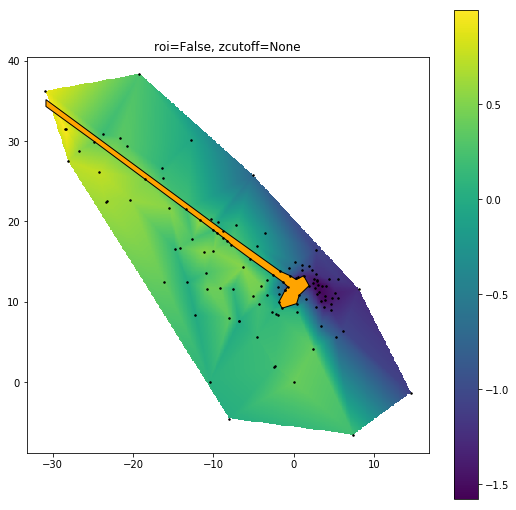

In [95]:
%matplotlib inline
si.plotAll(roi=False, zcutoff=None, figsize=(9,9))

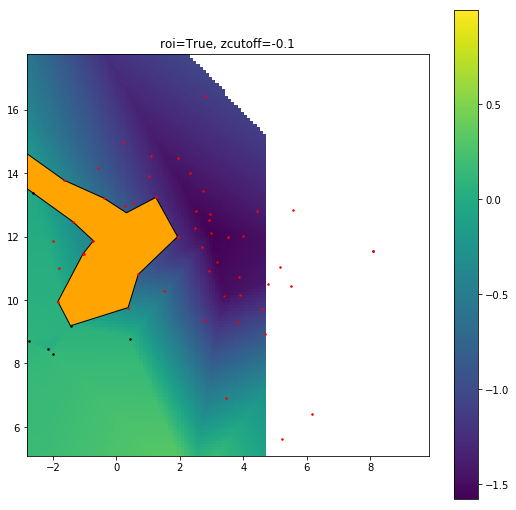

In [96]:
%matplotlib inline
si.plotAll(roi=True, zcutoff=-0.1, figsize=(9,9))

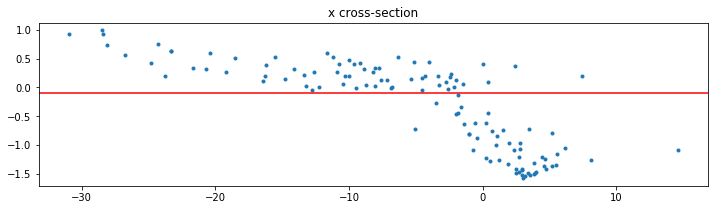

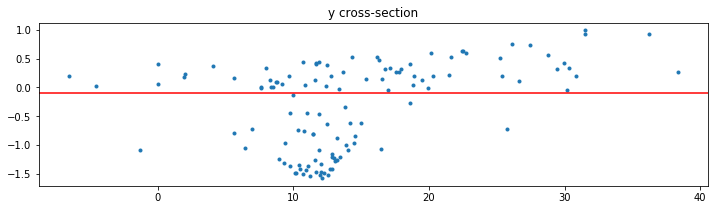

In [100]:
%matplotlib inline
si.plotCrossSection(axis='x', zcutoff=-0.1, figsize=(12,3))
si.plotCrossSection(axis='y', zcutoff=-0.1, figsize=(12,3))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less


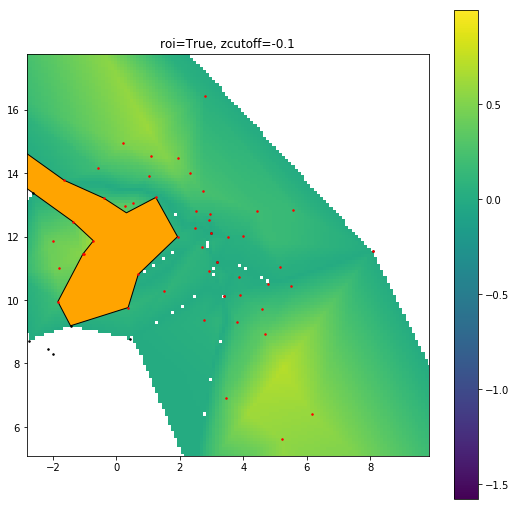

Difference=49.7 m³, zcutoff=-0.1


49.725390347065293

In [107]:
%matplotlib inline
si.plotDifference(roi=True, zcutoff=-.1, figsize=(9,9))
si.getDifferenceVolume(zcutoff=-.1)
#si.showCutout(-0.1)
#si.explore()

#si.plotAll(-0.5)